In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


In [4]:
data = '/content/GoogleDrive/My Drive/PlantVillage/'

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(df) # batch size is 32. 32 * 68 = 2176

68

In [8]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 0 0 2 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]


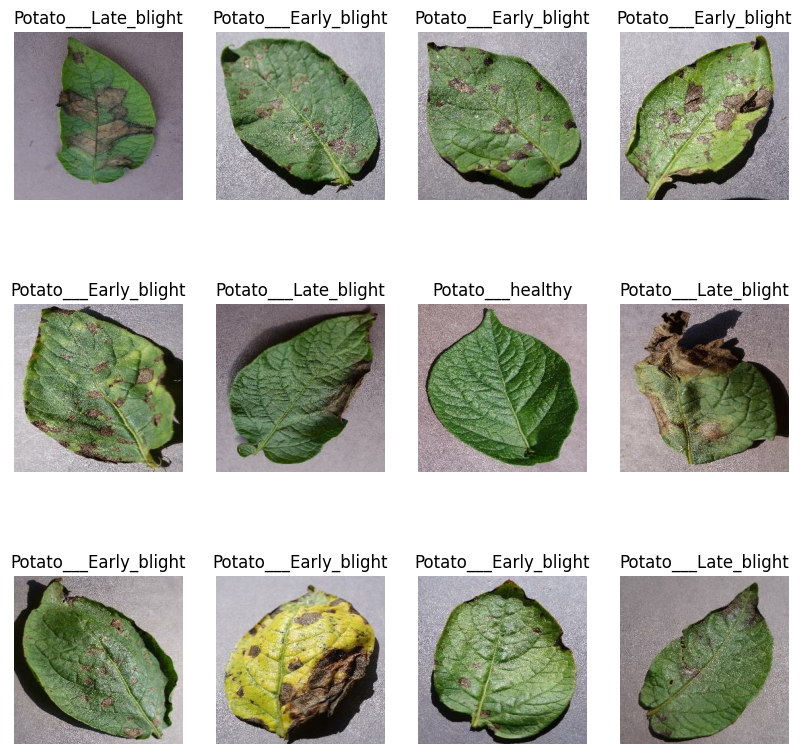

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [10]:
train_size = 0.8
len(df) * 0.8

54.400000000000006

In [11]:
train_ds = df.take(54)
len(train_ds)

54

In [12]:
test_ds = df.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(df) * val_size

6.800000000000001

In [14]:
val_size = test_ds.take(6)
len(val_size)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_datset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_datset_partition_tf(df)

In [18]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [21]:
data_augumentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augumentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [25]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 155s 138ms/step - loss: 0.9216 - accuracy: 0.4982 - val_loss: 0.9526 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.6786 - accuracy: 0.7388 - val_loss: 0.6553 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.4765 - accuracy: 0.8345 - val_loss: 0.4170 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 3s 58ms/step - loss: 0.3307 - accuracy: 0.8697 - val_loss: 0.3108 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 3s 58ms/step - loss: 0.3217 - accuracy: 0.8697 - val_loss: 0.3610 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2231 - accuracy: 0.9155 - val_loss: 0.3548 - val_accuracy: 0.8385
Epoch 7/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2226 - accuracy: 0.9184 - val_loss: 0.3336 - val_accuracy: 0.8542
Epoch 8/50

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 28ms/step - loss: 0.0286 - accuracy: 0.9844


In [27]:
scores

[0.02861810475587845, 0.984375]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
# history.history['accuracy']

In [32]:
len(history.history['accuracy'])

50

In [33]:
acc = history.history['accuracy']
val_loss = history.history['val_loss']

loss = history.history['loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

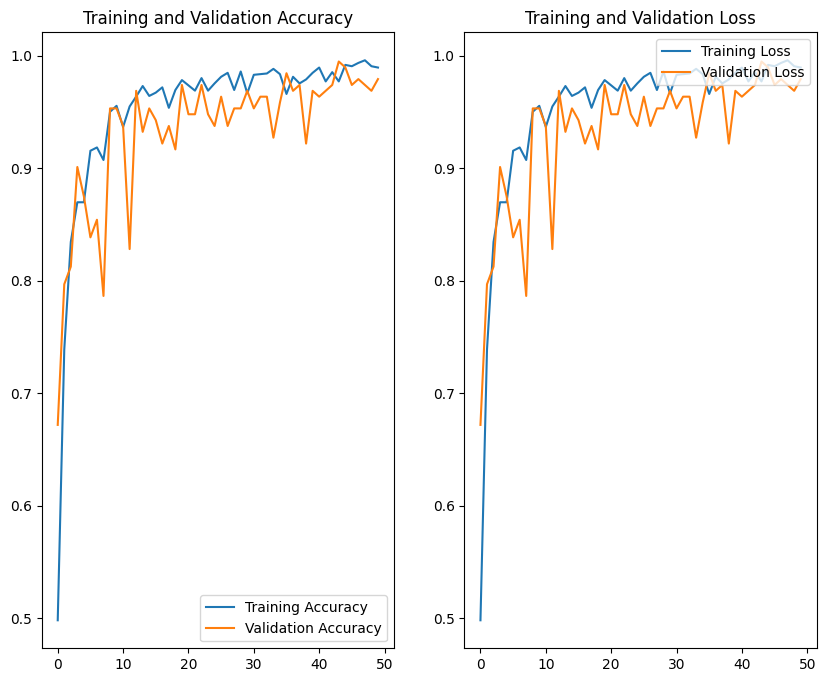

In [34]:
plt.figure(figsize=(10,8))
plt.subplot(1,2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), acc, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

First image to predict
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 165ms/step
Predicted Label :  Potato___Late_blight


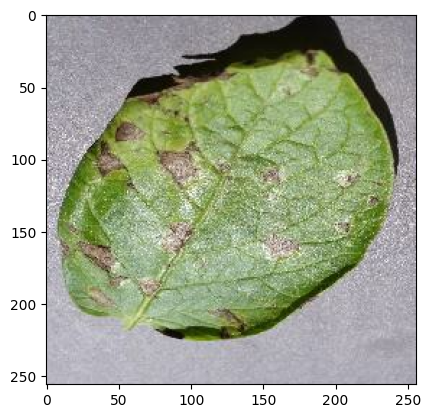

In [35]:
for images_batch, label_batch in test_ds.take(1):

    first_image = images_batch[i].numpy().astype('uint8')
    first_label = label_batch[i].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label : ", class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


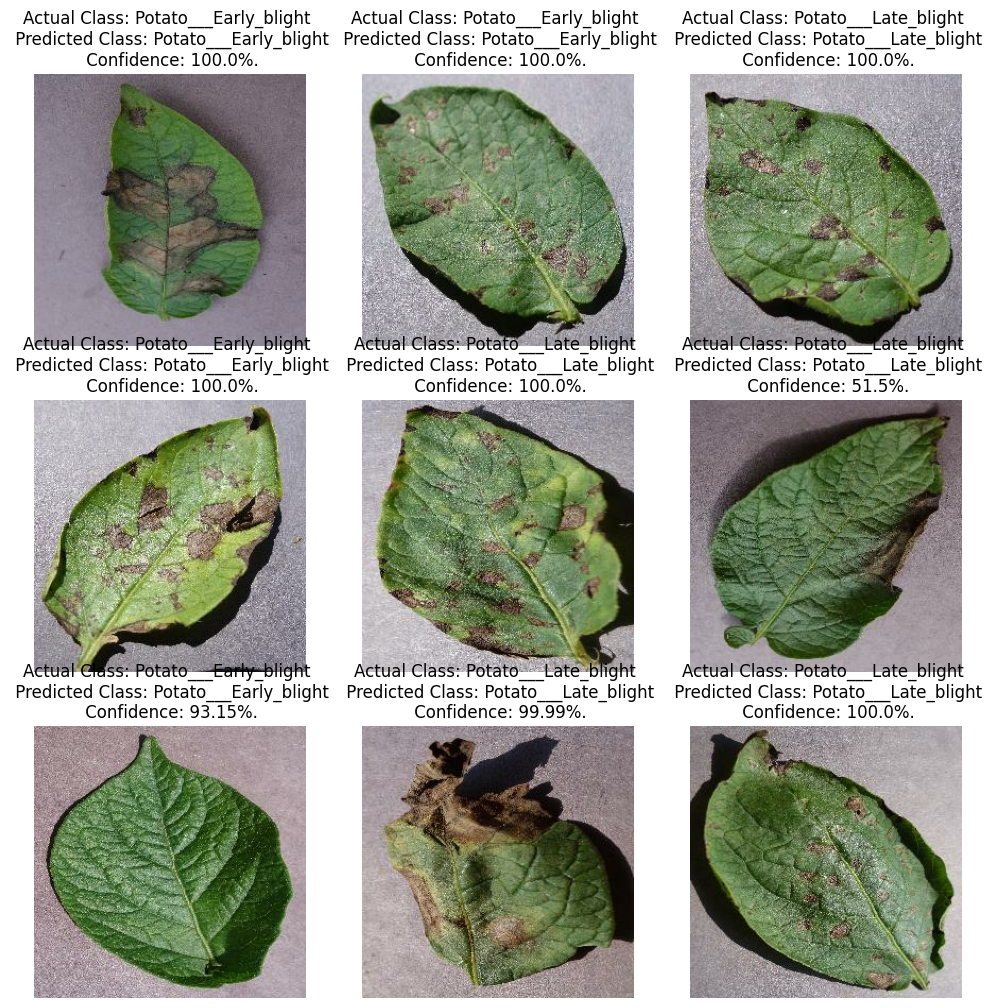

In [37]:
plt.figure(figsize=(12,12))
for images, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[label[i]]

        plt.title(f"Actual Class: {actual_class} \n Predicted Class: {predicted_class}\n Confidence: {confidence}%.")

        plt.axis("off")


In [39]:
model.save('my_model.h5')